In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline


In [36]:
path = 'table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'
data = pd.read_excel(path, header=4)
df = pd.DataFrame(data)
df.columns = df.columns.str.replace('\n',' ', regex=True)
df = df[:-3]
df = df.drop('Rape (revised definition)1', axis=1)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
City                                    348 non-null object
Population                              348 non-null float64
Violent crime                           348 non-null float64
Murder and nonnegligent manslaughter    348 non-null float64
Rape (legacy definition)2               348 non-null float64
Robbery                                 348 non-null float64
Aggravated assault                      348 non-null float64
Property crime                          348 non-null float64
Burglary                                348 non-null float64
Larceny- theft                          348 non-null float64
Motor vehicle theft                     348 non-null float64
Arson3                                  187 non-null float64
dtypes: float64(11), object(1)
memory usage: 31.3+ KB
None
                       City  Population  Violent crime  \
0             Adams Village      1861.0        

In [31]:
# propertycrime = alpha + Population + Populations**2 + Murder + Robbery

# create the property crime dataframe
property_crime_df = pd.DataFrame()

# add the population and population squared to the dataset
property_crime_df['Population'] = df['Population']
property_crime_df['Population Squared'] = df['Population']**2

# For the murder and robbery columns - set up a binary coding such that
# 0 = 0 and >0 = 1
property_crime_df['Murder'] = np.where(df['Murder and nonnegligent manslaughter'] > 0, 1, 0)
property_crime_df['Robbery'] = np.where(df['Robbery'] > 0, 1, 0)

print(property_crime_df.head())

#for col in property_crime_df.columns:
   # print(col)
    #plt.plot(property_crime_df[col])
   # plt.show()

# there is an obvious outlier in the population
#print(df.iloc[property_crime_df.Population.idxmax()])

# The outlier here is the population of NYC which is accurate 8.3million in 2013
# let's look at the next highest population

print(df.Population.nlargest(2).tolist()[1])

#print(df.iloc[35])

   Population  Population Squared  Murder  Robbery
0      1861.0        3.463321e+06       0        0
1      2577.0        6.640929e+06       0        0
2      2846.0        8.099716e+06       0        0
3     97956.0        9.595378e+09       1        1
4      6388.0        4.080654e+07       0        1
258789.0


So we do have an outlier in the population that we will likely have to deal with.  I am thinking I will replace that value with the next highest population which is Buffalo.

In [43]:
ind = property_crime_df.Population.idxmax()
repval = df.Population.nlargest(2).tolist()[1]

dropped_property_crime_df = property_crime_df
dropped_property_crime_df.loc[ind, 'Population'] = repval
print(dropped_property_crime_df.iloc[216])

Population            2.587890e+05
Population Squared    7.049493e+13
Murder                1.000000e+00
Robbery               1.000000e+00
Name: 216, dtype: float64


In [29]:
def linregfunc(X, Y):
    
    regr = linear_model.LinearRegression()
    
    regr.fit(X, Y)
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared:')
    print(regr.score(X, Y))
    
    # Extract predicted values.
    predicted = regr.predict(X).ravel()
    actual = Y

    # Calculate the error, also called the residual.
    residual = actual - predicted
    
    # Plot residuals to see the multivariate normality
    plt.hist(residual, edgecolor='k')
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()
    
    # Plot the predicted values vs residuals to check homoscedasticity
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()
    
    correlation_matrix = X.corr()
    display(correlation_matrix)


Coefficients: 
 [ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]

Intercept: 
 -109.57533562257231

R-squared:
0.9961247104988709


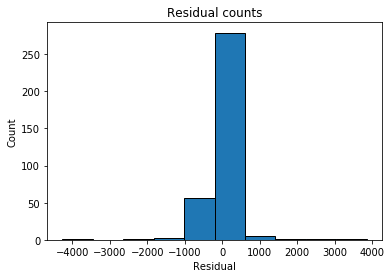

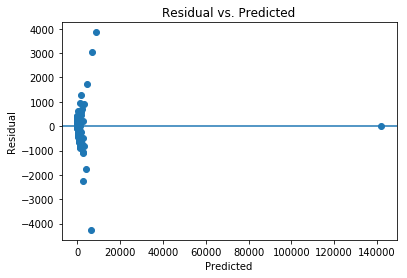

,Population,Population Squared,Murder,Robbery
Population,1.000000,0.998264,0.162309,0.064371
Population Squared,0.998264,1.000000,0.133067,0.043983
Murder,0.162309,0.133067,1.000000,0.313271
Robbery,0.064371,0.043983,0.313271,1.000000


In [33]:
# regression using the features set up in the example
X = property_crime_df
Y = df['Property crime']
linregfunc(X, Y)


Coefficients: 
 [ 3.40303554e-02  1.89158974e-09  1.73693570e+01 -9.11402522e+01]

Intercept: 
 -106.90259170003924

R-squared:
0.9961952738686498


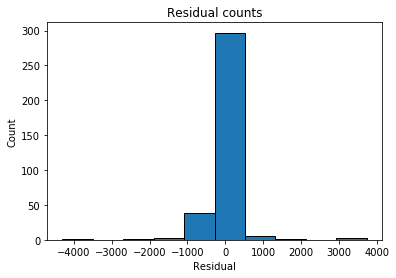

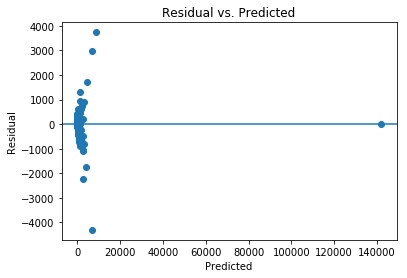

,Population,Population Squared,Murder,Robbery
Population,1.000000,0.434816,0.506480,0.328960
Population Squared,0.434816,1.000000,0.133067,0.043983
Murder,0.506480,0.133067,1.000000,0.313271
Robbery,0.328960,0.043983,0.313271,1.000000


In [44]:
# now with population outlier dropped
X_1 = dropped_property_crime_df
linregfunc(X_1, Y)


Coefficients: 
 [1.99256120e-09 1.18406016e+03 3.00052598e+02]

Intercept: 
 40.08610470544852

R-squared:
0.9859871204030131


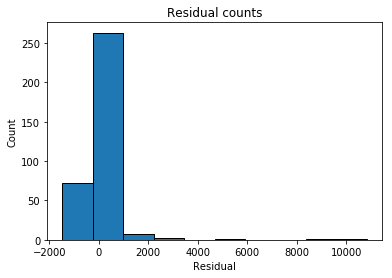

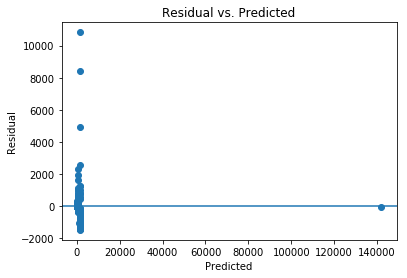

,Population Squared,Murder,Robbery
Population Squared,1.000000,0.133067,0.043983
Murder,0.133067,1.000000,0.313271
Robbery,0.043983,0.313271,1.000000


In [34]:
# population and population squared have too much correlation - drop population
X1 = property_crime_df.drop('Population', axis=1)
linregfunc(X1, Y)


Coefficients: 
 [1.68728222e-02 6.07383740e+02 1.06994709e+02]

Intercept: 
 -32.72226823930714

R-squared:
0.99344854357257


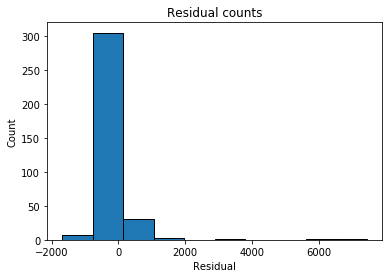

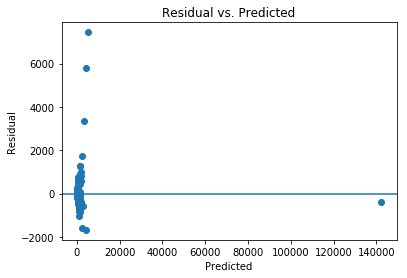

,Population,Murder,Robbery
Population,1.000000,0.162309,0.064371
Murder,0.162309,1.000000,0.313271
Robbery,0.064371,0.313271,1.000000


In [35]:
# population and population squared have too much correlation - drop population squared
X2 = property_crime_df.drop('Population Squared', axis=1)
linregfunc(X2, Y)


Coefficients: 
 [ 0.00000000e+00  1.82076576e-14  5.84410992e-14  8.62591248e-15
 -2.58126853e-14 -2.22044605e-14  1.00000000e+00  1.00000000e+00
  1.00000000e+00]

Intercept: 
 1.2505552149377763e-12

R-squared:
1.0


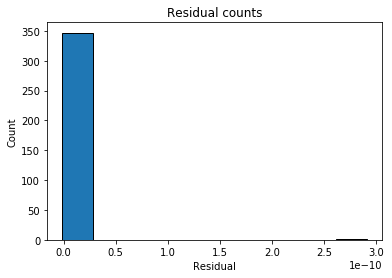

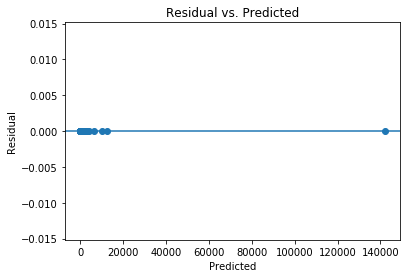

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Burglary,Larceny- theft,Motor vehicle theft
Population,1.000000,0.998854,0.986758,0.990839,0.998469,0.999134,0.970578,0.997946,0.992421
Violent crime,0.998854,1.000000,0.992098,0.994985,0.999923,0.999942,0.978150,0.998762,0.996271
Murder and nonnegligent manslaughter,0.986758,0.992098,1.000000,0.997746,0.993104,0.990843,0.993733,0.993175,0.997992
Rape (legacy definition)2,0.990839,0.994985,0.997746,1.000000,0.995438,0.994140,0.992442,0.996260,0.998764
Robbery,0.998469,0.999923,0.993104,0.995438,1.000000,0.999742,0.979525,0.998735,0.996927
Aggravated assault,0.999134,0.999942,0.990843,0.994140,0.999742,1.000000,0.976288,0.998561,0.995403
Burglary,0.970578,0.978150,0.993733,0.992442,0.979525,0.976288,1.000000,0.982700,0.991464
Larceny- theft,0.997946,0.998762,0.993175,0.996260,0.998735,0.998561,0.982700,1.000000,0.996878
Motor vehicle theft,0.992421,0.996271,0.997992,0.998764,0.996927,0.995403,0.991464,0.996878,1.000000


In [39]:
# let's try with all of the complete numeric variables in the dataset 
# drop city and arson3

X3 = df.drop(['City', 'Arson3', 'Property crime'], axis=1)
linregfunc(X3, Y)

We can clearly see that our coefficients for the first 6 variables is essentially 0, while the last 3 are 1.  Let's drop the first 6 variables due to how little they seem to impact the model.


Coefficients: 
 [1. 1. 1.]

Intercept: 
 1.4779288903810084e-12

R-squared:
1.0


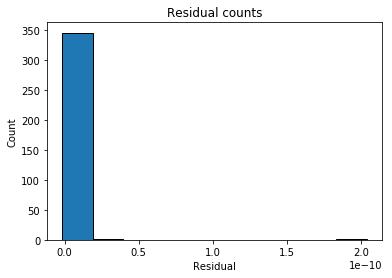

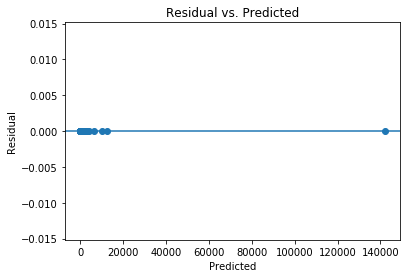

,Burglary,Larceny- theft,Motor vehicle theft
Burglary,1.000000,0.982700,0.991464
Larceny- theft,0.982700,1.000000,0.996878
Motor vehicle theft,0.991464,0.996878,1.000000


In [45]:
X4 = df[['Burglary', 'Larceny- theft', 'Motor vehicle theft']]
linregfunc(X4, Y)

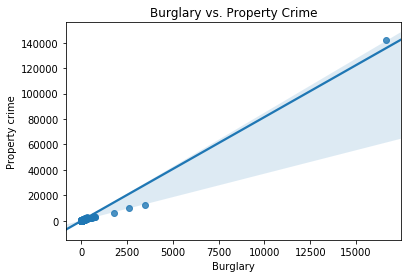

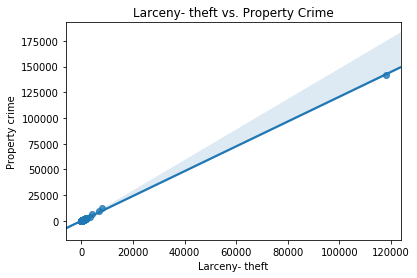

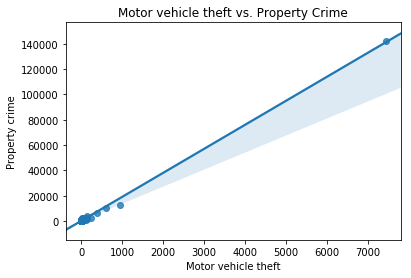

In [49]:
for x in X4.columns:
    sns.regplot(x=df[x], y=df['Property crime'])
    plt.title(str(x)+' vs. Property Crime')
    plt.show()

In [55]:
def get_residuals(X, Y):
    
    regr = linear_model.LinearRegression()
    
    regr.fit(X, Y)
       
    # Extract predicted values.
    predicted = regr.predict(X).ravel()
    actual = Y

    # Calculate the error, also called the residual.
    residual = actual - predicted
    
    # Create dataframe to view predicted, actual, and residuals
    resdf = pd.DataFrame([predicted, actual, residual]).T
    resdf.columns = ['Predicted', 'Actual', 'Residual']
    resdf = resdf.sort_values(by='Residual')
    
    return resdf.head(), resdf.tail()

In [56]:
get_residuals(X4, Y)

(        Predicted  Actual      Residual
 13   5.000000e+00     5.0 -1.479705e-12
 186  1.477929e-12     0.0 -1.477929e-12
 208  1.477929e-12     0.0 -1.477929e-12
 256  1.477929e-12     0.0 -1.477929e-12
 287  1.477929e-12     0.0 -1.477929e-12,
      Predicted    Actual      Residual
 218     2807.0    2807.0  6.366463e-12
 310     6473.0    6473.0  1.546141e-11
 272    10051.0   10051.0  2.364686e-11
 35     12491.0   12491.0  2.910383e-11
 216   141971.0  141971.0  2.037268e-10)

We have linear relationships between our outcome variable and the 3 feature variables, the error (residual) from the model is essentially 0 giving us the homoscedasticity - there one residual that is arguably an outlier associated with the city of NY. We do have a lot of correlation between these 3 features but since our goal is to predict the property crime, covering the variance is more important than being able to determining the strength of the features individually.




Coefficients: 
 [1. 1. 1.]

Intercept: 
 2.2737367544323206e-13

R-squared:
1.0


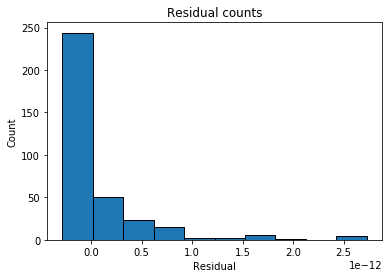

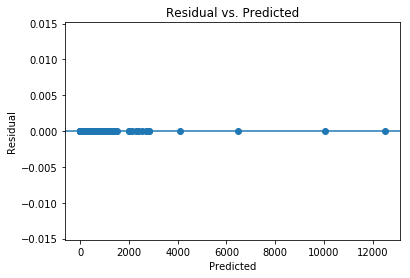

,Burglary,Larceny- theft,Motor vehicle theft
Burglary,1.000000,0.949552,0.976357
Larceny- theft,0.949552,1.000000,0.916178
Motor vehicle theft,0.976357,0.916178,1.000000


In [57]:
# let's see what happens if we drop NYC

X5 = X4.drop(index=216)
Y1 = Y.drop(index=216)
linregfunc(X5, Y1)

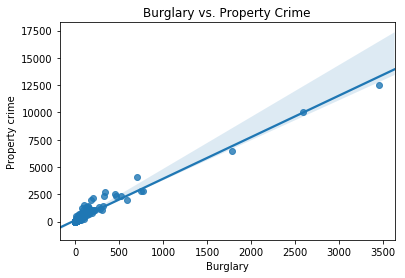

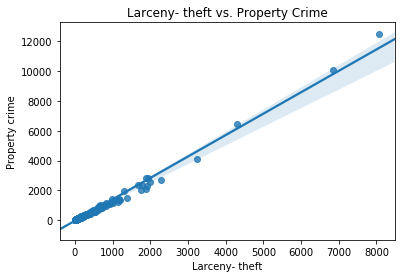

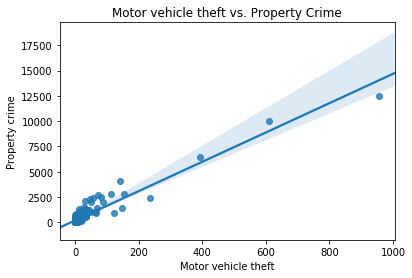

In [60]:
for x in X5.columns:
    sns.regplot(x=X5[x], y=Y1)
    plt.title(str(x)+' vs. Property Crime')
    plt.show()

In [61]:
get_residuals(X5, Y1)

(     Predicted  Actual      Residual
 199      276.0   276.0 -2.842171e-13
 99       162.0   162.0 -2.557954e-13
 263       33.0    33.0 -2.415845e-13
 230       54.0    54.0 -2.415845e-13
 104       50.0    50.0 -2.415845e-13,     Predicted  Actual      Residual
 57     1515.0  1515.0  2.046363e-12
 62     1990.0  1990.0  2.501110e-12
 3      4090.0  4090.0  2.728484e-12
 7      2118.0  2118.0  2.728484e-12
 53     2689.0  2689.0  2.728484e-12)